In [1]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
#from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
pho_path = './data/train_photos'
bus_path = './data/train.csv'
pho_label = 'photo_tag.csv' 
pho_bus = './data/train_photo_to_biz_ids.csv'

In [4]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [5]:
######separate training and testing set based on the business_id
train = list(bus.head(1500)['business_id'])
test = list(bus.head(500)['business_id'])
total = list(bus['business_id'])
total_label = list(bus['labels'])

In [6]:
test_img = cv2.imread(pho_path+'/'+'52779.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

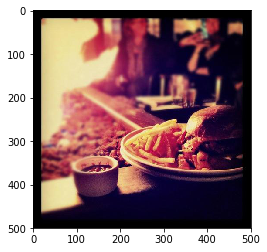

In [7]:
plt.imshow(test_img)
plt.show()

In [8]:
len(img_bus.loc[img_bus['business_id']==385])

59

In [9]:
#########filter the business, remove every business with zero label and zero image
def filter_business(total_business,total_label):
    new_bus = []
    new_label = []
    for t_b,t_l in zip(total_business,total_label):
        if type(t_l) == float or len(img_bus.loc[img_bus['business_id']==t_b])==0:
            continue
        else:
            new_bus.append(t_b)
            new_label.append(t_l)
    return new_bus,new_label

In [10]:
total,total_label = filter_business(total,total_label)

In [11]:
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [12]:
##############this is used to get the feature img from flattern layer based on each business
##############we only collect img_num photos, when the number of photos < img_num, we collect all of them
def collect_map(model_extractfeatures,business_id,img_num):
    #bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        test_img = image.load_img(pho_path+'/'+str(img)+'.jpg', target_size=(224,224))
        x = image.img_to_array(test_img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_set.append(x)
    img_set = np.array(img_set)
    img_set = np.reshape(img_set,(img_set.shape[0],224,224,3))
    bus_feature = model_extractfeatures.predict(img_set)
    #################return the set of feature and the number of photo for each business
    return bus_feature,len(bus_feature)#np.array(bus_feature)
        

In [13]:
#########the bus_feature should be 2-dimension
#########this is used to reduce the dimension for each image
#########the business here is a set of business, this function will return the reduaction dimension feature for all images
from sklearn.decomposition import PCA
def bus_PCA(business,model_extractfeatures,red_dim,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    
    pca = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        feature_map = np.vstack((feature_map,bus_feature))
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    ########now we have all the feature map with size n X 25088, n is the total image numbers 
    if len(feature_map)<red_dim:
        print('There are only {0:10} images, less than {1:10d}'.format(len(feature_map), red_dim))
    pca = pca.fit(feature_map)
    pca_feature = pca.transform(feature_map)
    return pca_feature,photo_num#pca.components_

In [14]:
################used to get the final feature for each business
def get_bus_map(pca_feature):
    return pca_feature.sum(axis=0)/float(pca_feature.shape[0])

In [15]:
############combine the function above to get the final feature for 
def get_total_map(business,model_extractfeatures,red_dim,img_num):
    
    ################get the total set for pca features and number of business photos
    pca_features,bus_pho_num = bus_PCA(business,model_extractfeatures,red_dim,img_num)
    
    ###############get the first feature vector for business
    start = 0
    end = bus_pho_num[0]
    bus_feature_map = get_bus_map(pca_features[start:end])
    start = end
    
    for num in bus_pho_num[1:]:
        end = start + num
        bus_f_map = get_bus_map(pca_features[start:end])
        start = end
        bus_feature_map = np.vstack((bus_feature_map,bus_f_map))
        
    return np.array(bus_feature_map)

In [16]:
#############one hot here should be multi hot :)
def get_one_hot(total_label):
    labels = []
    count = 0
    for t_l in total_label:
        l = [0 for i in range(9)]
        #print(count)
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        count+=1
        labels.append(l)
    return np.array(labels)

In [65]:
def F1_score(test_y,predict_y):
    tp = (test_y*predict_y).sum(axis=1)
    fp=[]
    fn=[]
    for t_y,p_y in zip(test_y,predict_y):
        false_p = 0
        false_n = 0
        for t,p in zip(t_y,p_y):
            if t==0 and p==1:
                false_p+=1.
            if t==1 and p==0:
                false_n+=1.
        fp.append(false_p)  
        fn.append(false_n) 
    fp = np.array(fp)
    fn = np.array(fn)
    #print(tp,fp,fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    #print(p,r)
    F1 = []
    for p,r in zip(precision,recall):
        if p==0 and r==0:
            F1.append(0)
        else:
            F1.append(2*(p*r)/(p+r))
    #print(F1)
    F1 = np.array(F1)
    F1_final = F1.sum()/len(F1)
    return F1,F1_final

In [28]:
###########train_num is the number of business we want to choose from business_id
###########test_num is number we want to choose from the test_business_id, train_num+test_num should less than 1996
###########red_dim is the dimension we want the PCA to get, 
###########img_num is the number we want at most from each business


def train(train_num,test_num,model_extractfeatures,red_dim,img_num):
    ##############the feature map should be (n,128) n here is 2000
    print('Begin feature extracting')
    feature_map = get_total_map(total[:train_num],model_extractfeatures,red_dim,img_num)
    train_label = get_one_hot(total_label[:train_num])
    print('Finish feature extracting')
    
    print('Begin training')
    ##############training part
    classifier = OneVsRestClassifier(svm.SVC(C=0.1,kernel='sigmoid', probability=True))
    classifier.fit(feature_map,train_label)
    print('Finish training')
    
    print('Begin Predicting')
    ##############prediction part
    test_x = get_total_map(total[train_num:train_num+test_num],model_extractfeatures,red_dim,img_num)
    pred_y = classifier.predict(test_x)
    print('Finish predicting')
    
    test_y = get_one_hot(total_label[train_num:train_num+test_num])
    
    ##############evaluation
    F1_final,F1 = F1_score(test_y,pred_y)
    return F1_final,F1,pred_y,test_y

In [29]:
##################here we use 500 train_business_id and 50 test_business_id
train_num = 500
test_num = 50
red_dim = 1024
img_num = 100

vgg = VGG16(weights='imagenet')
model_extractfeatures = Model(input=vgg.input, output=vgg.get_layer('flatten').output)

##################we set 300 as the features for each business, for eaach business we take at most 800 images
F1_final,F1,pred_y,test_y = train(train_num,test_num,model_extractfeatures,red_dim,img_num)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  


Begin feature extracting
Percent: [--------------------------------------->] 100%Finish feature extracting
Begin training
Finish training
Begin Predicting
Percent: [--------------------------------------->] 100%Finish predicting


In [30]:
F1

0.6115184815184815

In [ ]:
print(test_y,pred_y)

In [61]:
##################check corresponding image for the label we predict
#least_img = 0
#target_bus = 0
count = 0
for b_id in total[train_num:train_num+test_num]:
    img_list = list(img_bus.loc[img_bus['business_id']==b_id]['photo_id'])
    print('b_id is {0:1d}, number of photos is {1:1d}, index is {2:1d}'.format(b_id,len(img_list),count))
    count+=1

b_id is 1850, number of photos is 299, index is 0
b_id is 1851, number of photos is 16, index is 1
b_id is 1853, number of photos is 14, index is 2
b_id is 1854, number of photos is 26, index is 3
b_id is 1856, number of photos is 334, index is 4
b_id is 1862, number of photos is 13, index is 5
b_id is 186, number of photos is 103, index is 6
b_id is 1864, number of photos is 41, index is 7
b_id is 1865, number of photos is 25, index is 8
b_id is 1866, number of photos is 64, index is 9
b_id is 1869, number of photos is 86, index is 10
b_id is 187, number of photos is 8, index is 11
b_id is 1873, number of photos is 79, index is 12
b_id is 1875, number of photos is 46, index is 13
b_id is 1877, number of photos is 51, index is 14
b_id is 1880, number of photos is 40, index is 15
b_id is 1882, number of photos is 18, index is 16
b_id is 1883, number of photos is 39, index is 17
b_id is 188, number of photos is 72, index is 18
b_id is 1885, number of photos is 74, index is 19
b_id is 188

In [63]:
###########only output nine photos
def plot_img(business_id):
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    num = 11
    if num>len(img_list):
        num = len(img_list)
    position = 1
    plt.figure(figsize=(15,15))
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        plt.subplot(3,4,position)
        plt.imshow(cv2.resize(test_img,(224,224)))
        plt.axis('off')
        position+=1
    plt.show()

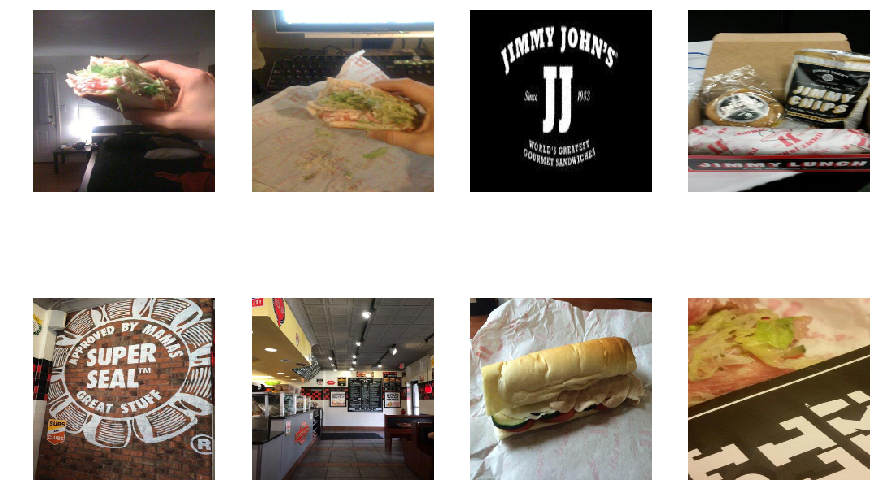

In [64]:
plot_img(187)

In [33]:
test_y[11],pred_y[11]

(array([1, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 1, 1, 0, 0, 1, 1, 0, 1]))

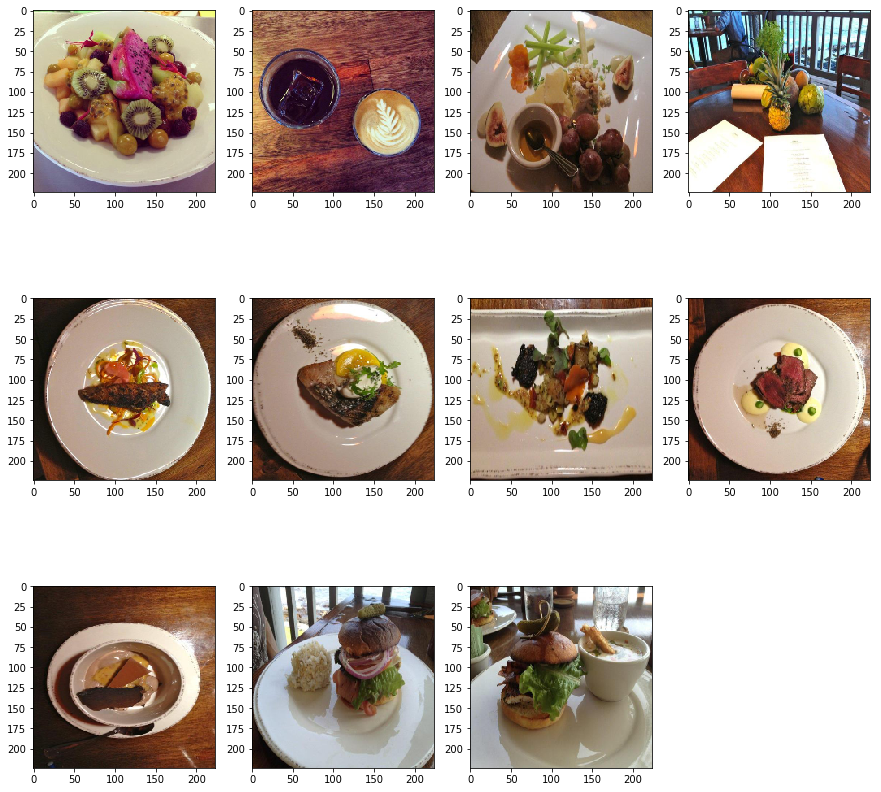

(array([0, 0, 1, 1, 0, 1, 1, 1, 1]), array([0, 1, 1, 1, 0, 1, 1, 0, 0]))

In [62]:
plot_img(1915)
test_y[37],pred_y[37]